In [27]:
import pickle
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy.optimize import minimize

In [3]:
# Load the saved model
with open("../models/arima_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("../models/arima_model_bnd.pkl", "rb") as f:
    bnd_model = pickle.load(f)

with open("../models/arima_model_spy.pkl", "rb") as f:
    spy_model = pickle.load(f)

In [4]:
tsla = pd.read_csv("../data/TSLA_cleaned.csv", parse_dates=True, index_col="Date")
bnd = pd.read_csv("../data/BND_cleaned.csv", parse_dates=True, index_col="Date")
spy = pd.read_csv("../data/SPY_cleaned.csv", parse_dates=True, index_col="Date")

In [5]:
tsla.index = pd.date_range(start=tsla.index[0], periods=len(tsla), freq="D")

In [6]:
# Split into train (80%) and test (20%)
train_size = int(len(tsla) * 0.8)
train, test = tsla['Close'][:train_size], tsla['Close'][train_size:]

In [7]:
# Define future steps (252 trading days = ~1 year)
future_steps = 252

# Ensure the last date from the dataset is correct
last_date = train.index[-1]  

# Generate future dates
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_steps, freq='B')  # 'B' ensures business days

# Forecast using the trained ARIMA model
forecast_object = loaded_model.get_forecast(steps=future_steps)

# Extract the forecasted mean values
forecast_values = forecast_object.predicted_mean

# Convert to DataFrame
forecast_df = pd.DataFrame({"Date": future_dates, "Forecast": forecast_values})

# Set Date as Index
forecast_df.set_index("Date", inplace=True)

# Display first few rows
print(forecast_df.head())

                           Forecast
Date                               
2020-07-22 05:00:00+00:00  0.284644
2020-07-23 05:00:00+00:00  0.284913
2020-07-24 05:00:00+00:00  0.284803
2020-07-27 05:00:00+00:00  0.284848
2020-07-28 05:00:00+00:00  0.284830


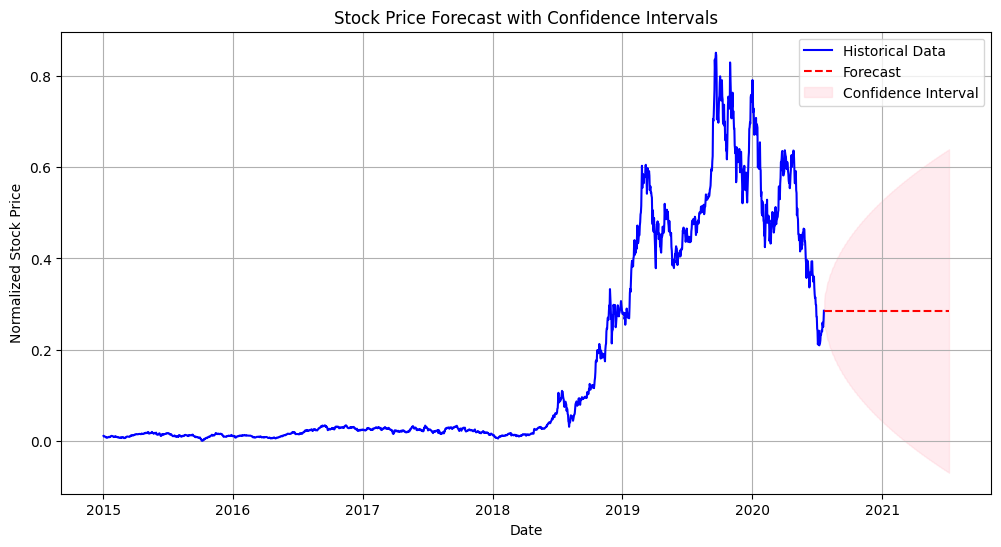

In [18]:
# Get confidence intervals
confidence_intervals = forecast_object.conf_int()

# Extract lower and upper bounds
lower_bounds = confidence_intervals.iloc[:, 0]
upper_bounds = confidence_intervals.iloc[:, 1]

# Plot historical data
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Historical Data", color="blue")

# Plot forecasted data
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color="red", linestyle="dashed")

# Fill between confidence intervals
plt.fill_between(forecast_df.index, lower_bounds, upper_bounds, color="pink", alpha=0.3, label="Confidence Interval")

# Plot settings
plt.title("Stock Price Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Normalized Stock Price")
plt.legend()
plt.grid()
plt.show()

In [20]:
# Extract forecasted values
forecast_values = forecast_df["Forecast"]
lower_bounds = confidence_intervals.iloc[:, 0]
upper_bounds = confidence_intervals.iloc[:, 1]

# Calculate trend direction
trend_direction = "Upward" if forecast_values.iloc[-1] > forecast_values.iloc[0] else "Downward" if forecast_values.iloc[-1] < forecast_values.iloc[0] else "Stable"

# Calculate rolling volatility (Standard Deviation of forecasted prices)
rolling_volatility = forecast_values.rolling(window=30).std()

# Identify periods of increased volatility
high_volatility_periods = rolling_volatility[rolling_volatility > rolling_volatility.mean()].index

# Check for significant price movements (potential market opportunities/risks)
price_increase = (forecast_values.pct_change().mean()) > 0
expected_volatility = rolling_volatility.mean()

# Interpretation Summary
interpretation = {
    "Trend": trend_direction,
    "Forecast Start Price": round(forecast_values.iloc[0], 4),
    "Forecast End Price": round(forecast_values.iloc[-1], 4),
    "Average Expected Volatility": round(expected_volatility, 4),
    "High Volatility Periods": list(high_volatility_periods.strftime('%Y-%m-%d')),
    "Market Opportunity": "Price Increase Expected" if price_increase else "Potential Price Decline",
    "Confidence Interval Width": round((upper_bounds - lower_bounds).mean(), 4),
}

# Print the results
for key, value in interpretation.items():
    print(f"{key}: {value}")

Trend: Upward
Forecast Start Price: 0.2846
Forecast End Price: 0.2848
Average Expected Volatility: 0.0
High Volatility Periods: ['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-07', '2020-09-08']
Market Opportunity: Price Increase Expected
Confidence Interval Width: 0.4744


In [12]:
# Forecast using the trained ARIMA model
forecast_object_bnd = bnd_model.get_forecast(steps=future_steps)

# Extract the forecasted mean values
forecast_values_bnd = forecast_object_bnd.predicted_mean

# Convert to DataFrame
forecast_df_bnd = pd.DataFrame({"Date": future_dates, "Forecast": forecast_values_bnd})

# Set Date as Index
forecast_df_bnd.set_index("Date", inplace=True)

# Display first few rows
print(forecast_df_bnd.head())

                           Forecast
Date                               
2020-07-22 05:00:00+00:00  0.410829
2020-07-23 05:00:00+00:00  0.410895
2020-07-24 05:00:00+00:00  0.410910
2020-07-27 05:00:00+00:00  0.410914
2020-07-28 05:00:00+00:00  0.410915


In [13]:
# Forecast using the trained ARIMA model
forecast_object_spy = spy_model.get_forecast(steps=future_steps)

# Extract the forecasted mean values
forecast_values_spy = forecast_object_spy.predicted_mean

# Convert to DataFrame
forecast_df_spy = pd.DataFrame({"Date": future_dates, "Forecast": forecast_values_spy})

# Set Date as Index
forecast_df_spy.set_index("Date", inplace=True)

# Display first few rows
print(forecast_df_spy.head())

                           Forecast
Date                               
2020-07-22 05:00:00+00:00  0.513699
2020-07-23 05:00:00+00:00  0.513864
2020-07-24 05:00:00+00:00  0.513784
2020-07-27 05:00:00+00:00  0.513823
2020-07-28 05:00:00+00:00  0.513804


In [17]:
# Combine Forecasts into a Single DataFrame
df = pd.DataFrame({
    "TSLA": forecast_values,
    "BND": forecast_values_bnd,
    "SPY": forecast_values_spy
})

# Display results
print(df.head())

# Save forecasts for portfolio optimization
df.to_csv("../data/forecasted_prices.csv")

                               TSLA       BND       SPY
2020-07-22 05:00:00+00:00  0.284644  0.410829  0.513699
2020-07-23 05:00:00+00:00  0.284913  0.410895  0.513864
2020-07-24 05:00:00+00:00  0.284803  0.410910  0.513784
2020-07-25 05:00:00+00:00  0.284848  0.410914  0.513823
2020-07-26 05:00:00+00:00  0.284830  0.410915  0.513804


In [33]:
daily_returns = df.pct_change().dropna()  # Calculate daily returns
annual_returns = daily_returns.mean() * 252  # Annualize returns

# Compute Covariance Matrix (Risk Relationship Between Assets)
cov_matrix = daily_returns.cov() * 252  # Annualized covariance

# Define Portfolio Weights (Equal Weights Initially)
num_assets = len(df.columns)
initial_weights = np.array([1/num_assets] * num_assets)

# Compute Portfolio Return and Volatility
def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.dot(weights, returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Sharpe Ratio Maximization
risk_free_rate = 0.02  # Assuming 2% risk-free rate

# Define Sharpe Ratio Function (Return / Risk)
def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    port_return, port_volatility = portfolio_performance(weights, returns, cov_matrix)
    return -(port_return - risk_free_rate) / port_volatility  # Negative for minimization

# Optimize Portfolio Weights
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Sum of weights = 1
bounds = tuple((0, 1) for _ in range(num_assets))  # Weights between 0 and 1

optimized_result = sco.minimize(
    sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix, risk_free_rate),
    method="SLSQP", bounds=bounds, constraints=constraints
)

# Optimized Portfolio Weights
optimized_weights = optimized_result.x
opt_return, opt_volatility = portfolio_performance(optimized_weights, annual_returns, cov_matrix)

# Compute Portfolio Risk Metrics
VaR_95 = np.percentile(daily_returns["TSLA"], 5)  # 5% worst-case Tesla loss
sharpe_ratio_value = -optimized_result.fun  # Convert back to positive

# Print Results
print("\nOptimized Portfolio Allocation")
print(pd.DataFrame({"Asset": df.columns, "Weight": optimized_weights}))

print("\nPortfolio Performance")
print(f" Expected Annual Return: {opt_return:.4f}")
print(f" Expected Volatility (Risk): {opt_volatility:.4f}")
print(f" Sharpe Ratio: {sharpe_ratio_value:.4f}")
print(f" Value at Risk (VaR 95% for TSLA): {VaR_95:.4f}")


Optimized Portfolio Allocation
  Asset        Weight
0  TSLA  1.000000e+00
1   BND  7.719436e-12
2   SPY  3.015754e-12

Portfolio Performance
 Expected Annual Return: 0.0007
 Expected Volatility (Risk): 0.0010
 Sharpe Ratio: -18.5622
 Value at Risk (VaR 95% for TSLA): -0.0000
